# Low rank approximation for the numerical simulation of high dimensional Lindblad and Riccati equations
https://arxiv.org/pdf/1207.4580


In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import dynamiqs as dq
import matplotlib.pyplot as plt
import qutip as qt
import time
from itertools import product, accumulate

## Global Parameters

### Numerical Parameters

In [2]:
global_rtol=1e-6
global_atol=1e-6
max_steps = 5000000
tmax = 100
tsteps_sample = 200
tsteps_full = 10000
sample_times = jnp.linspace(0, tmax, tsteps_sample)
full_times = jnp.linspace(0,tmax, tsteps_full)
do_td_drive = False

### Physical Parameters

In [3]:
omega_r = 7.4
omega_f = 7.45
g = 0.3
J = 0.03
kappa = 0.03

# Readout drive parameters.
omega_d = omega_r
epsilon = 0.03

In [4]:
Nmax_LC = 80
root2 = np.sqrt(2)
psi0 = None

c_op_coeff = 1
drive_coeff = 1

Nmax_qubit = 6  # 5, We would like this to be 30.
Nmax_resonator = 4  # 10, We would like this to be 100.
Nmax_filter = 4  # 3, We would like this to be 10.

psi0_np = np.zeros((Nmax_qubit * Nmax_filter * Nmax_resonator, 1))
psi0_np[5] = 1
psi0 = qt.Qobj(
    psi0_np,
    dims=[[Nmax_qubit, Nmax_resonator, Nmax_filter], [1, 1, 1]],
    shape=(60, 1),
)
EL = 2
EJ = 4
EC = 2

## QuTiP Setup

In [5]:
c_qt = qt.destroy(Nmax_LC)
n_LC_qt = -1j / root2 * (EL / (8 * EC)) ** (1.0 / 4.0) * (c_qt - c_qt.dag())
phi_LC_qt = 1 / root2 * (8 * EC / EL) ** (1.0 / 4.0) * (c_qt + c_qt.dag())
# Qubit Hamiltonian in the LC basis.
H_LC_qt = (
    4 * EC * n_LC_qt**2 + 0.5 * EL * phi_LC_qt**2 - EJ * (phi_LC_qt - np.pi).cosm()
)
evals_qt, evec_qt = H_LC_qt.eigenstates()
H_qubit_qt = qt.Qobj(np.diag(evals_qt[0:Nmax_qubit]))
n_eig_qt = n_LC_qt.transform(evec_qt)
n_eig_qt = qt.Qobj(n_eig_qt[:Nmax_qubit, :Nmax_qubit])

# Same in the composite Hilbert space.
H_qubit_qt = qt.tensor(H_qubit_qt, qt.qeye(Nmax_resonator), qt.qeye(Nmax_filter))
n_eig_qt = qt.tensor(n_eig_qt, qt.qeye(Nmax_resonator), qt.qeye(Nmax_filter))
# The resonator and filter Hamiltonians in the composite Hilbert space.
a_qt = qt.tensor(
    qt.qeye(Nmax_qubit), qt.destroy(Nmax_resonator), qt.qeye(Nmax_filter)
)
b_qt = qt.tensor(
    qt.qeye(Nmax_qubit), qt.qeye(Nmax_resonator), qt.destroy(Nmax_filter)
)
H_resonator_qt = omega_r * a_qt.dag() * a_qt
H_filter_qt = omega_f * b_qt.dag() * b_qt
# Interaction terms.
V_qr_qt = -1j * g * n_eig_qt * (a_qt - a_qt.dag())
V_qf_qt = -J * (a_qt - a_qt.dag()) * (b_qt - b_qt.dag())
# Collapse operator.
c_op_qt = c_op_coeff * np.sqrt(kappa) * b_qt
# Time-independent Hamiltonian.
H_idle_qt = H_qubit_qt + H_resonator_qt + H_filter_qt + V_qr_qt + V_qf_qt

### JAX Globals

In [6]:
c_dq = dq.destroy(Nmax_LC)
c_dag_dq = dq.dag(c_dq)
n_LC_dq = -1j / root2 * (EL / (8 * EC)) ** (1.0 / 4.0) * (c_dq - c_dag_dq)
phi_LC_dq = 1.0 / root2 * (8 * EC / EL) ** (1.0 / 4.0) * (c_dq + c_dag_dq)
H_LC_dq = (
    4 * EC * dq.powm(n_LC_dq, 2)
    + 0.5 * EL * dq.powm(phi_LC_dq, 2)
    - EJ * dq.cosm(phi_LC_dq - dq.eye(Nmax_LC) * np.pi)
)
evals_dq, evec_dq = jnp.linalg.eigh(H_LC_dq)  # TODO: make sparse

H_qubit_dq = jnp.diagflat(evals_dq[0:Nmax_qubit])
n_eig_dq = evec_dq @ (n_LC_dq @ dq.dag(evec_dq))  # equivalent to transform in qutip
n_eig_dq = n_eig_dq[:Nmax_qubit, :Nmax_qubit]

H_qubit_dq = dq.tensor(H_qubit_dq, dq.eye(Nmax_resonator), dq.eye(Nmax_filter))
n_eig_dq = dq.tensor(n_eig_dq, dq.eye(Nmax_resonator), dq.eye(Nmax_filter))
a_dq = dq.tensor(
    dq.eye(Nmax_qubit), dq.destroy(Nmax_resonator), dq.eye(Nmax_filter)
)
b_dq = dq.tensor(
    dq.eye(Nmax_qubit), dq.eye(Nmax_resonator), dq.destroy(Nmax_filter)
)
H_resonator_dq = omega_r * dq.dag(a_dq) @ a_dq
H_filter_dq = omega_f * dq.dag(b_dq) @ b_dq
V_qr_dq = -1j * g * n_eig_dq @ (a_dq - dq.dag(a_dq))
V_qf_dq = -J * (a_dq - dq.dag(a_dq)) @ (b_dq - dq.dag(b_dq))

L_dq = c_op_coeff * jnp.sqrt(kappa) * b_dq

H_idle_dq = H_qubit_dq + H_resonator_dq + H_filter_dq + V_qr_dq + V_qf_dq
H_drive_coeff_dq = lambda t: jnp.cos(omega_d * t)
H_drive_dq = dq.modulated(
    H_drive_coeff_dq, do_td_drive * drive_coeff * -2.0j * epsilon * (a_dq - dq.dag(a_dq))
)
H_dq = H_idle_dq + H_drive_dq

evals_dq, evec_dq = jnp.linalg.eigh(H_idle_dq) 
evals_dq, evec_dq = np.linalg.eigh(H_idle_qt.full())
evals_dq = jnp.array(evals_dq)
evec_dq = jnp.array(evec_dq)


number_dq, qubit_dq = dq.dag(a_dq) @ a_dq, dq.dag(b_dq) @ b_dq
dm0 = dq.todm(psi0_np)
dm0_jnp = jnp.asarray(dm0,dtype=complex)

## Dynamiqs, Full Rank

In [7]:
t1_dq = time.time()
dq_solver = dq.solver.Dopri5(
    rtol=global_rtol,
    atol=global_atol,
    max_steps=max_steps
)
result_mesolve_dq = dq.mesolve(
    H_dq,
    [L_dq],
    dm0_jnp,
    sample_times,
    exp_ops=[number_dq, qubit_dq],
    solver=dq_solver,
    options=dq.Options(),
)
n_t_dq = jnp.real(result_mesolve_dq.expects[0])
q_t_dq = jnp.real(result_mesolve_dq.expects[1])
t2_dq = time.time()
print(f"Dynamiqs Time: {np.round(t2_dq-t1_dq,3)}")

|██████████| 100.0% ◆ elapsed 13.35s ◆ remaining 0.00ms  


Dynamiqs Time: 14.389


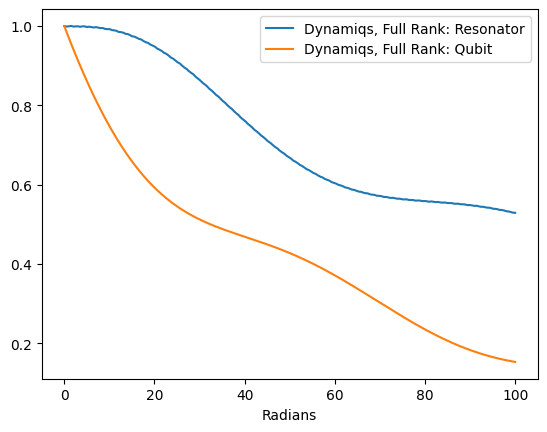

In [8]:
plt.plot(sample_times,n_t_dq,label="Dynamiqs, Full Rank: Resonator")
plt.plot(sample_times,q_t_dq,label="Dynamiqs, Full Rank: Qubit")
plt.xlabel("Radians")
plt.legend()
plt.show()

## Low Rank Setup

In [9]:
n = Nmax_filter*Nmax_qubit*Nmax_resonator
Hilbert_sizes = np.array([Nmax_qubit,Nmax_resonator,Nmax_filter])
reduction = np.array([1,2,2])
reduced_Hilbert = Hilbert_sizes/reduction
p = int(reduced_Hilbert[0]*reduced_Hilbert[1]*reduced_Hilbert[2])
print(f"Full Rank n={n}")
print(f"Low Rank p={p}")


Full Rank n=96
Low Rank p=24


### Initialization

In [10]:
@jax.jit
def qr_gram_schmidt(A):
    # more numerically stable than manual gram schmidting
    Q, _ = jnp.linalg.qr(A)
    return Q

def initialize_U_fourierpsi(psi0, n_i,p_i):
    # Fourier basis # TODO make first col actual eigenvec
    x_i = -1j*2*jnp.pi/n_i* jnp.arange(n_i)
    U_0 = jnp.column_stack(tuple([psi0] + [jnp.exp(x_i*k) for k in range(1,p_i)]))/jnp.sqrt(n_i)
    return qr_gram_schmidt(U_0)

def initialize_U_gaps(psi0,n_i, p_i):
    r = int(n_i/p_i)
    psi0 = psi0.flatten()
    U0 = np.zeros((n_i, p_i),dtype=complex)
    anchor = np.where(psi0 > 0)[0][0] # TODO allow for multiples
    stencil = np.zeros((p_i,))
    stencil[0] = 1/np.sqrt(r)
    U0[:,0] = psi0
    for i in range(1,p_i):
        U0[:,i] = np.roll(np.tile(stencil,r),anchor+i)
    return qr_gram_schmidt(jnp.array(U0))


In [43]:

@jax.jit
def dag(A):
    return jnp.conj(A).T
@jax.jit
def inv(A):
    return jnp.linalg.inv(A)
@jax.jit
def Tr(A):
     return jnp.linalg.trace(A)

I_n = jnp.eye(n)
I_p = jnp.eye(p)

def roundstr(val,tol=3) -> str:
    return str(jnp.round(val,tol))

def zstr(z):
    r = np.round(np.real(z),3)
    i = np.round(np.imag(z),3)
    r = str(r) if r != 0 else ""
    i = " + " + str(i)+"i" if i != 0 else ""
    zp = r + i
    return "{:<17}".format(zp)

def cprint(A):
    print("[")
    for i in range(A.shape[0]):
        print()
        print(f"\t[{"\t".join([zstr(val) for val in A[i,:].tolist()])}\t],")
    print("]")

def verify_unitary(A,n_i=10,verbosity=0):
    maybe = dag(A)@A
    return_case = jnp.isclose(jnp.abs(jnp.linalg.det(maybe)),1,atol=1e-2,rtol=1e-2)
    if verbosity > 0:
        print(f"Valid Unitary?:\t{return_case}, Det: {jnp.abs(jnp.linalg.det(maybe))}, Rank: {jnp.linalg.matrix_rank(maybe)}")
    if verbosity > 1:
        cprint(maybe[:n_i,:n_i])
    return return_case
def verify_dm(rho_i,verbosity=0):
    return_case = jnp.allclose(rho_i,dag(rho_i),rtol=1e-5,atol=1e-6) and np.isclose(Tr(rho_i),1)
    if verbosity > 0:
        print(f"Valid DM?:\t{return_case}")
    return return_case
def print_dm(rho_i,n_i=10,acc=5,verbosity=1):
    if verbosity > 1:
        for r in range(n_i):
            print(np.round(rho_i[r,:n_i],acc))
    if verbosity > 0:
        print(jnp.diagonal(rho_i)[:n_i])  
    
@jax.jit
def submanifold_step(U_k, sigma_k, dt, H, L):
    # https://arxiv.org/pdf/1207.4580 eq13-17
    HU_k = H@U_k
    H2U_k = H@HU_k
    H3U_k = H@H2U_k
    U_k_a = U_k - 1j*dt/2*HU_k - dt**2/8*H2U_k + 1j*dt**3/48*H3U_k
    LU_k_a = L@U_k_a
    dLU_k_a = dag(LU_k_a)
    dU_k_a = dag(U_k_a)
    U_k_b = U_k_a + dt*(I_n - U_k_a@dU_k_a) @ (- .5*dag(L)@LU_k_a + LU_k_a@sigma_k@dLU_k_a@U_k_a@inv(sigma_k))
    sigma_k_a = sigma_k + dt* dU_k_a@LU_k_a@sigma_k@dLU_k_a@U_k_a + dt * Tr((dLU_k_a@LU_k_a - dLU_k_a@U_k_a@dU_k_a@LU_k_a)@sigma_k) * I_p/p
    sigma_k_b1 = I_p - dt/2.*dLU_k_a@LU_k_a
    sigma_k_b = sigma_k_b1@sigma_k_a@sigma_k_b1
    sigma_k_c = sigma_k_b / Tr(sigma_k_b)
    HU_k_b = H@U_k_b
    H2U_k_b = H@HU_k_b
    H3U_k_b = H@H2U_k_b
    U_k_c = U_k_b - 1j*dt/2*HU_k_b - dt**2/8*H2U_k_b + 1j*dt**3/48*H3U_k_b
    U_k_d = qr_gram_schmidt(U_k_c)

    # TODO check work
    # compute errors from eq18 and a whole bunch of trace
    # UU' is an orthogonal projector so it is idempotent + symmetric + rank p
    # P = I_n - UU'
    # K = LU
    # A = PKsigmaK'P = A' \in C^(nxn) (never explicitly put in nxn form, manipulated so traced on pxp)
    # B = UU'/p Tr(LUsigmaU'L'P) = A' (ditto)
    # ...
    # Tr(rhodot_perp^2) = Tr(A^2) - 2Tr(AB) + Tr(B^2), Tr(AB) = 0
    U, sigma = U_k_d, sigma_k_c # shorthand
    LU = L@U # TODO reuse
    J = dag(U)@L
    dLU = dag(LU) # TODO
    # Tr(A^2)
    C = dLU @ (LU - U@(J@U)) # pxp
    A_m = C@sigma # pxp
    tr_A2 = Tr(A_m@A_m) # pxp
    # 2Tr(AB)
    d = Tr(A_m)
    # Tr(B^2) = d^2/p
    error = tr_A2 - d**2/p
    return U_k_d, sigma_k_c, error
    

In [44]:
epsilon_rho0 = 1e-5
tracer = epsilon_rho0*np.ones((p,))
tracer[0] = 1 - (p-1)*epsilon_rho0
sigma_0 = jnp.diagflat(jnp.array(tracer)) # TODO make same
verify_dm(sigma_0,verbosity=1)
print_dm(sigma_0)



U_0 = initialize_U_fourierpsi(psi0_np, n,p)
U_0 = initialize_U_gaps(psi0_np, n, p)
verify_unitary(U_0,verbosity=1)

Valid DM?:	True
[9.9977e-01 1.0000e-05 1.0000e-05 1.0000e-05 1.0000e-05 1.0000e-05
 1.0000e-05 1.0000e-05 1.0000e-05 1.0000e-05]
Valid Unitary?:	True, Det: 1.000000238418579, Rank: 24


Array(True, dtype=bool)

In [17]:
# N_t = tsteps
# @jax.jit
# def diffeq_solve():
#     dt = full_times[1]-full_times[0]
#     U_t = jnp.zeros((N_t,n,p),dtype=complex)
#     sigma_t = jnp.zeros((N_t,p,p),dtype=complex)
#     U_t = U_t.at[0,:,:].set(U_0)
#     sigma_t = sigma_t.at[0,:,:].set(sigma_0)
#     H_sm = H_dq
#     L_sm = L_dq
#     def step_body(i,paired): # TODO folding bug
#         U_t, sigma_t = paired
#         ti = 0 # TODO
#         U_plus, sigma_plus, _ = submanifold_step(
#             U_k=U_t[i-1,:,:],
#             sigma_k=sigma_t[i-1,:,:],
#             dt=dt,
#             H=H_sm(ti),
#             L=L_sm
#         )
#         return U_t.at[i,:,:].set(U_plus), sigma_t.at[i,:,:].set(sigma_plus)
#         # verify_dm(sigma_t[i,:,:],verbosity=1)
#         # verify_unitary(U_t[i,:,:],verbosity=1)
#     return jax.lax.fori_loop(1,N_t,step_body,(U_t,sigma_t))

# U_sm, sigma_sm = diffeq_solve()

In [18]:
# @jax.jit
# def rebuild_rho(U_t, sigma_t):
#     rho_t = jnp.zeros((tsteps_full,n,n),dtype=complex)
#     def rho_body(i,rho_ti):
#         return rho_ti.at[i,:,:].set(U_t[i,:,:]@sigma_t[i,:,:]@dag(U_t[i,:,:]))
#     return jax.lax.fori_loop(0,tsteps_full,rho_body, rho_t)
# rho_sm = rebuild_rho(U_sm, sigma_sm)
# n_sm = jnp.real(dq.expect(number_dq,rho_sm))
# q_sm = jnp.real(dq.expect(qubit_dq, rho_sm))

In [19]:
# plt.plot(full_times,n_sm,label="Naive, Low Rank: Resonator")
# plt.plot(full_times,q_sm,label="Naive, Low Rank: Qubit")
# plt.legend()
# plt.xlabel("Radians")
# plt.show()

## Diffraxing

In [20]:
import diffrax as dx

### Diffrax, Full Rank

In [45]:
def term_dq(t, y, args):
    dL_dq = dag(L_dq)
    LdL = dL_dq @ L_dq
    tmp = (-1j * H_dq(t) -.5 * LdL) @ y + .5 * (L_dq @ y @ dL_dq)
    return tmp + dag(tmp)

terms_dq = dx.ODETerm(term_dq)

sol_dx_dq = dx.diffeqsolve(
    terms=terms_dq,
    solver=dx.Dopri5(),
    t0=sample_times[0],
    t1=tmax,
    dt0=full_times[1]-full_times[0],
    y0=dm0_jnp,
    args=None,
    saveat=dx.SaveAt(ts=sample_times),
    max_steps=max_steps,
    progress_meter=dx.TqdmProgressMeter(refresh_steps=1000)
)
rho_dx_dq = sol_dx_dq.ys

/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/equinox/_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)
/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an 

XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/asyncio/base_events.py", line 641, in run_forever
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/asyncio/events.py", line 88, in _run
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/var/folders/_6/p1fbgzt907zchhn08n4rmzrw0000gn/T/ipykernel_26739/3052646834.py", line 9, in <module>
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/equinox/_jit.py", line 206, in __call__
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/equinox/_module.py", line 1053, in __call__
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/equinox/_jit.py", line 200, in _call
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/traceback_util.py", line 179, in reraise_with_filtered_traceback
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/pjit.py", line 327, in cache_miss
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/pjit.py", line 185, in _python_pjit_helper
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/core.py", line 2834, in bind
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/core.py", line 420, in bind_with_trace
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/core.py", line 921, in process_primitive
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/pjit.py", line 1635, in _pjit_call_impl
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/pjit.py", line 1614, in call_impl_cache_miss
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/pjit.py", line 1568, in _pjit_call_impl_python
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/profiler.py", line 335, in wrapper
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/interpreters/pxla.py", line 1244, in __call__
  File "/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py", line 2476, in _wrapped_callback
KeyboardInterrupt: 

In [22]:
n_t_dx_dq = jnp.real(dq.expect(number_dq, rho_dx_dq))
q_t_dx_dq = jnp.real(dq.expect(qubit_dq, rho_dx_dq))

### Diffrax, Low Rank

In [36]:
"""
for all the dirty details, see https://docs.kidger.site/jaxtyping/ and https://docs.kidger.site/diffrax/usage/extending/
JAX & GPUs for Quantum Engineers
JAX is fast and built for GPUs/TPUs.
Terms:  XLA = Accelerated Linear Algebra - ie the 
        LAX = like 
        JIT = Just-in-time compiling

A custom solver must be implented for the scheme involves more than just programming in the numerical integration step. 
Custom objects (AbstractTerm subclasses) must be declared as well as corresponding PyTree jaxtyping. PyTrees allow users to handle
complicated data structures while simultaneously allowing the XLA backend to manipulate them quickly. Equinox is the standard library
for doing enabling classes to act like PyTrees, though jaxtyping is also quite useful for smaller objects. Diffrax and by extension Dynamiqs
objects are essentially all subclassed from equinox.Module which does the PyTree handling.
"""
from jaxtyping import PyTree, ArrayLike, Shaped, Array
from typing import TypeVar, TypeAlias, Union, Callable, Any

from numpy import ndarray
JUMP: TypeAlias = PyTree[Shaped[ArrayLike, "?*jump"], "JUMP"] # declares a custom batchable object (denoted *) of name JUMP that can vary in size (denoted ?) across instances
_JUMP: TypeVar = TypeVar("_JUMP", bound=JUMP)
HMT: TypeAlias = PyTree[Shaped[ArrayLike, "?*hmt"], "HMT"]
_HMT: TypeVar = TypeVar("_HMT",bound=HMT)
LINDBLAD: TypeAlias = tuple[HMT, JUMP]
_LINDBLAD: TypeVar = TypeVar("_LINDBLAD", bound=LINDBLAD)

RHOP: TypeAlias = PyTree[Shaped[ArrayLike, "?*rhop"], "RHOP"]
_RHOP: TypeVar = TypeVar("_RHOP",bound=RHOP)

FloatScalarLike = Union[float, Array, np.ndarray]
IntScalarLike = Union[int, Array, np.ndarray]
RealScalarLike = Union[FloatScalarLike, IntScalarLike]

class LindbladTerm(dx.AbstractTerm[_LINDBLAD, RealScalarLike]):
    hamiltonian: Callable[[RealScalarLike], HMT]
    jump: Callable[[RealScalarLike], JUMP] # TODO assumes stacked if multiple
    def vf(self, t: RealScalarLike, y: RHOP, args) -> LINDBLAD: 
        return (self.hamiltonian(t), self.jump(t))
    def contr(self, t0: RealScalarLike, t1: RealScalarLike, **kwargs) -> RealScalarLike:
        return 0
    def prod(self, vf: Any, control: RealScalarLike):
        return 0


In [51]:

class ClosedSubmanifoldSolver(dx.AbstractSolver):
    # https://arxiv.org/pdf/1207.4580

    term_structure = LindbladTerm
    interpolation_cls = dx.LocalLinearInterpolation

    def order(self, terms):
        return 1
    def init(self, terms, t0, t1, y0, args):
        return None
    
    def step(self,
             terms: LindbladTerm,
             t0: RealScalarLike,
             t1: RealScalarLike,
             y0: RHOP,
             args: None,
             solver_state: None,
             made_jump: None,
        ):
        # unpacking
        del solver_state, made_jump
        npp, p_i = y0.shape
        n_i = npp -p_i
        U_k = y0[:n_i,:]
        sigma_k = y0[n_i:,:]
        H_t, L_t = terms.vf(t=t0,y=None,args=None)
        # procedure
        U_k1, sigma_k1, error_norm = submanifold_step(
            U_k=U_k,
            sigma_k=sigma_k,
            dt=t1-t0,
            H=H_t,
            L=L_t
        )
        # repacking 
        y1 = jnp.vstack((U_k1,sigma_k1))
        dense_info = dict(y0=y0,y1=y1)
        solver_state = None
        result = dx.RESULTS.successful
        y1_error = None# error_norm
        return y1, y1_error, dense_info, solver_state, result

    def func(self, terms, t0, y0, args):
        return 0

In [52]:
terms_sm = LindbladTerm(
    hamiltonian=lambda t: H_dq(t),
    jump=lambda t: L_dq
)
y0_sm = jnp.vstack((U_0,sigma_0))
solver_sm = ClosedSubmanifoldSolver()
sol_dx_sm = dx.diffeqsolve(
    terms=terms_sm,
    solver=solver_sm,
    t0=sample_times[0],
    t1=tmax,
    dt0=full_times[1]-full_times[0], # TODO
    y0=y0_sm,
    args=None,
    saveat=dx.SaveAt(ts=sample_times),
    max_steps=max_steps,
    progress_meter=dx.TqdmProgressMeter(refresh_steps=100),
    # stepsize_controller=dx.PIDController(rtol=1e-3,atol=1e-5)
)


/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/equinox/_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)
/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/opt/anaconda3/envs/hamsim/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an 

In [53]:
US_dx_sm = sol_dx_sm.ys

@jax.jit
def rebuild_rho_stacked(US_t):
    tot_shape = US_t.shape
    npp = tot_shape[1]
    p_i = tot_shape[2]
    n_i = npp - p_i
    U_t = US_t[:,:n_i,:]
    sigma_t = US_t[:,n_i:,:]
    rho_t = jnp.zeros((tot_shape[0],n_i,n_i),dtype=complex)
    def rho_body(i,rho_ti):
        return rho_ti.at[i,:,:].set(U_t[i,:,:]@sigma_t[i,:,:]@dag(U_t[i,:,:]))
    return jax.lax.fori_loop(0,tsteps_full,rho_body, rho_t)
rho_dx_sm = rebuild_rho_stacked(US_dx_sm)
n_t_dx_sm = jnp.real(dq.expect(number_dq, rho_dx_sm))
q_t_dx_sm = jnp.real(dq.expect(qubit_dq, rho_dx_sm))

## Comparisons

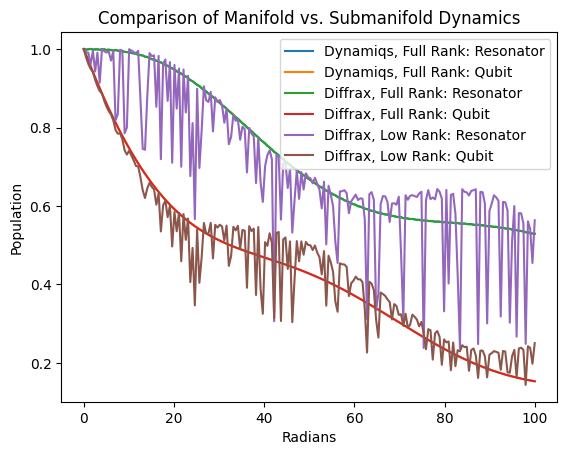

In [54]:
plt.plot(sample_times,n_t_dq,label="Dynamiqs, Full Rank: Resonator")
plt.plot(sample_times,q_t_dq,label="Dynamiqs, Full Rank: Qubit")
plt.plot(sample_times,n_t_dx_dq,label="Diffrax, Full Rank: Resonator")
plt.plot(sample_times,q_t_dx_dq,label="Diffrax, Full Rank: Qubit")
plt.plot(sample_times,n_t_dx_sm,label="Diffrax, Low Rank: Resonator")
plt.plot(sample_times,q_t_dx_sm,label="Diffrax, Low Rank: Qubit")
plt.legend()
plt.xlabel("Radians")
plt.ylabel("Population")
plt.title("Comparison of Manifold vs. Submanifold Dynamics")
plt.show()

TODO
* DONE verify stays on manfiold
* DONE verify $U_{k+1}^{\dagger}U_{k+1} = I_p \forall k$
* DONE convert all np to jnp
* DONE verify diffrax solver vs dq solution
* DONE make initial conditions psi_0 while keeping good normalization
* verify actually works
* compute condition numbers
* figure out right basis
* jit everything
* benchmark scaling to find breakpoint for outperforming
* diffrax as custom abstract solver
* figure out how dq gets so much faster than raw diffrax
* dynamiqs-style exp_ops callbacks within diffrax
* stepsize controller based on condition number


# Simulation Scaling
Matrix-Vector Tim Time Stepping:
* Time per step $O(n^2)$
* Storage per step $O(n)$

Dense-Dense Matrix Mult:
* Time $O(n^3)$
* Storage per step $O(n^2)$



## Time-Dependent Numerical Scheme Scaling


Sizing:
* levels in Hilbert space is $n$ $\sim 10^{4.5}$
  * Hamiltonian takes $n\times n$ as dense, $n\times m$ sparse
  * Liouvillian takes $n^2 \times n^2$ as dense, $n^2 \times (2m + \sum_k c_k)$ sparse
  * number of nonzero diagonals in $H$ is $m$ $\sim 20$
  * number of nonzero diagonals for the $k^{th}$ jump operator = $c_k$ $\sim1$
  * levels in projected Hilbert space is $p$
* computational time steps $ N_t \sim 10^6$
* storage time steps $N_s \sim 10^{2.5}$
* Wavefunction takes $n$ as dense
* Density matrix takes $n\times n$ as dense, $n \times p$ and $p \times p$ as sparse
* $n^2 \approx 10^9 \implies$ 1GB storage
* Space assumes you want to store the state at each time step
### Schemes
Schrodinger: full wavefunction vector, dense Hamiltonian
* store $n$ vector, operations matrix-vector
* Time $\rightarrow O(n^2 N_t)$
* Space $\rightarrow O(nN_s)$
* QuTiP, Dynamiqs

Schrodinger: full wavefunction vector, sparse Hamiltonian
* store $n$ vector, operations sparse matrix-vector
* Time $\rightarrow O(nmN_t)$
* Space  $\rightarrow O(nN_s)$
* soon to be Dynamiqs

Lindblad: full density matrix, dense Liouvillian
* store $n\times n$ matrix, operations dense matrix-matrix
* Time $\rightarrow O(n^3N_t)$
* Space $\rightarrow O(n^2N_s)$
* QuTiP, Dynamiqs

Lindblad: full density matrix, sparse Liouvillian
* store $n \times n$ matrix, operations sparse matrix-dense matrix
* Time $\rightarrow O(n^2mN_t)$
* Space $\rightarrow O(n^2N_s)$
* soon to be Dynamiqs

Lindblad: projected density matrix, sparse Liouvillian
* store $p\times p$ and $n\times p$ matrices, operations sparse matrix-dense matrix
* Time $\rightarrow O(npmN_t)$
* Space $\rightarrow O(np + p^2N_s)$
* Implementing from paper: https://arxiv.org/pdf/1207.4580
